# Better CNNs using regularization

Dataset of 60,000 28x28 grayscale images of 10 fashion categories, along with a test set of 10,000 images. This dataset can be used as a drop-in replacement for MNIST. The class labels are:

Label Description

- 0 T-shirt/top
- 1 Trouser
- 2 Pullover
- 3 Dress
- 4 Coat
- 5 Sandal
- 6 Shirt
- 7 Sneaker
- 8 Bag
- 9 Ankle boot

This dataset is available from Keras

## Importing the necessary libraries

In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

C:\Users\direc\Anaconda3\envs\recipes-ai\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


## Loading the dataset

In [2]:
from keras.datasets import fashion_mnist
(X_train, y_train), (X_test, y_test) = fashion_mnist.load_data()

n_train = y_train.shape[0]
n_test = y_test.shape[0]
n_categories = 10

Using TensorFlow backend.


## Take a look at the dataset

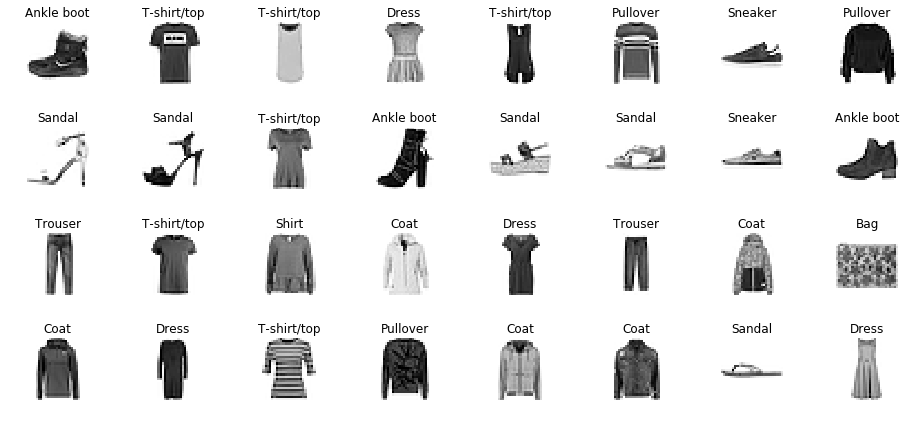

In [3]:
categories = {0:'T-shirt/top', 1:'Trouser', 2:'Pullover', 3:'Dress', 4:'Coat',
                 5:'Sandal', 6:'Shirt', 7:'Sneaker', 8:'Bag', 9:'Ankle boot'}

fig, axes = plt.subplots(nrows=4, ncols=8, figsize=(13,6))
for i, ax in enumerate(axes.flatten()):
    ax.imshow(X_train[i], cmap='Greys')
    ax.set_title(categories[y_train[i]])
    ax.axis('off')

fig.tight_layout()

## Preprocesing the data

In [4]:
## Reshaping and rescaling images:
X_train = X_train.reshape(n_train, 28, 28, 1)/255.
X_test = X_test.reshape(n_test, 28, 28, 1)/255.

## Getting validation and test sets
X_val = X_test[:1000]
X_test = X_test[1000:]

y_val = y_test[:1000]
y_test = y_test[1000:]
## Here we can use 1000 for test and validation and the reset for training

## Build the input pipeline

In [5]:
BATCH_SIZE = 128

train_dataset = tf.data.Dataset.from_tensor_slices((X_train, y_train))
train_dataset = train_dataset.shuffle(buffer_size=10000)
train_dataset = train_dataset.batch(BATCH_SIZE)
iterator = train_dataset.make_initializable_iterator()
next_element = iterator.get_next()

## Building the CNN model

In [6]:
training = tf.placeholder_with_default(False, shape=[])
dropout_rate = 0.4
def cnn(inputs):
    ## 2 - Convolutions + 1 - maxpooling
    conv1 = tf.layers.conv2d(inputs, filters=16, kernel_size=3, strides=1,
                             padding='same', activation=tf.nn.relu)
    conv2 = tf.layers.conv2d(conv1, filters=32, kernel_size=3, strides=1,
                             padding='same', activation=tf.nn.relu)
    max_pooling1 = tf.layers.max_pooling2d(conv2, pool_size=2, strides=2, padding='valid')
    ## 2 - Convolutions + 1 - maxpooling    
    conv3 = tf.layers.conv2d(max_pooling1, filters=32, kernel_size=3, strides=1,
                             padding='same', activation=tf.nn.relu)
    conv4 = tf.layers.conv2d(conv3, filters=64, kernel_size=3, strides=1,
                             padding='same', activation=tf.nn.relu)
    max_pooling2 = tf.layers.max_pooling2d(conv4, pool_size=2, strides=2, padding='valid')
    
    dropout1 = tf.layers.dropout(max_pooling2, rate=dropout_rate, training=training)
    
    ## Flatten + dense + dropout + dense + dense
    flatten = tf.layers.flatten(dropout1)
    dense1 = tf.layers.dense(flatten, units=64, activation=tf.nn.relu)
    dropout2 = tf.layers.dropout(dense1, rate=dropout_rate, training=training)
    dense2 = tf.layers.dense(dropout2, units=32, activation=tf.nn.relu)
    
    ## Output
    logits = tf.layers.dense(dense2, units=n_categories)
    return logits

## Create placeholders to pass values for training and evaluation

In [7]:
X_placeholder_shape = [None] + list(X_train.shape[1:])
X = tf.placeholder(tf.float32, shape=X_placeholder_shape)
y = tf.placeholder(tf.int32)

## Define the loss, optimizer and training operation

In [8]:
logits = cnn(X)
loss = tf.losses.sparse_softmax_cross_entropy(labels=y, logits=logits)
optimizer = tf.train.AdamOptimizer() ## here we are changing optimizer
training_op = optimizer.minimize(loss)

## Getting predictions and metrics

In [9]:
y_pred_proba = tf.nn.softmax(logits)
y_pred = tf.argmax(y_pred_proba, axis=1, output_type=tf.int32)

correct = tf.equal(y_pred, y)
accuracy = 100*tf.reduce_mean(tf.cast(correct, tf.float32))

## Write a function for running the training operation

In [10]:
def train_model(epoch):
    iterator.initializer.run()
    while True:
        try:
            X_values, y_values = sess.run(next_element)
            sess.run(training_op, feed_dict={X: X_values, y:y_values, training:True})
        except tf.errors.OutOfRangeError:
            break
    train_acc = sess.run(accuracy, feed_dict={X: X_values, y:y_values})
    val_acc = sess.run(accuracy, feed_dict={X: X_val, y:y_val})
    print('Epoch: {:d}, Training Accuracy: {:0.1f}% | Validation Accuracy {:0.1f}%'.format(epoch, train_acc, val_acc))
    return train_acc, val_acc

## Run the computational graph

In [11]:
N_EPOCHS = 50
accuracy_metrics = np.zeros((N_EPOCHS, 2))
with tf.Session() as sess:
    tf.global_variables_initializer().run()
    for epoch in range(N_EPOCHS):
        accuracy_metrics[epoch] = train_model(epoch+1)
    print("Done training")
    test_preds = sess.run(y_pred_proba, feed_dict={X: X_test[:1500], y:y_test[:1500]})

Epoch: 1, Training Accuracy: 90.6% | Validation Accuracy 85.9%
Epoch: 2, Training Accuracy: 89.6% | Validation Accuracy 87.8%
Epoch: 3, Training Accuracy: 90.6% | Validation Accuracy 89.6%
Epoch: 4, Training Accuracy: 91.7% | Validation Accuracy 89.6%
Epoch: 5, Training Accuracy: 92.7% | Validation Accuracy 91.0%
Epoch: 6, Training Accuracy: 92.7% | Validation Accuracy 91.3%
Epoch: 7, Training Accuracy: 93.8% | Validation Accuracy 92.0%
Epoch: 8, Training Accuracy: 89.6% | Validation Accuracy 92.5%
Epoch: 9, Training Accuracy: 93.8% | Validation Accuracy 92.5%
Epoch: 10, Training Accuracy: 96.9% | Validation Accuracy 92.4%
Epoch: 11, Training Accuracy: 95.8% | Validation Accuracy 93.1%
Epoch: 12, Training Accuracy: 93.8% | Validation Accuracy 93.4%
Epoch: 13, Training Accuracy: 94.8% | Validation Accuracy 93.0%
Epoch: 14, Training Accuracy: 96.9% | Validation Accuracy 92.8%
Epoch: 15, Training Accuracy: 95.8% | Validation Accuracy 93.6%
Epoch: 16, Training Accuracy: 95.8% | Validation 

## Evaluation metrics

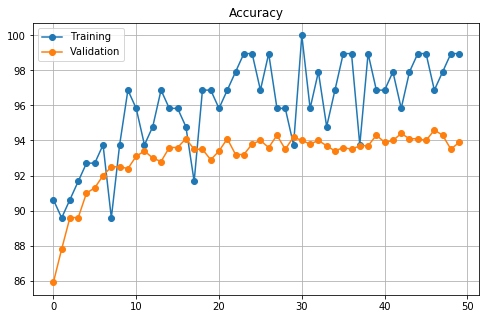

In [12]:
fig, ax = plt.subplots(figsize=(8,5))
ax.plot(np.arange(N_EPOCHS), accuracy_metrics[:,0], 'o-', label='Training')
ax.plot(np.arange(N_EPOCHS), accuracy_metrics[:,1], 'o-', label='Validation')
ax.legend(); ax.grid()
ax.set_title('Accuracy');

## Distribution of prediction probabilities

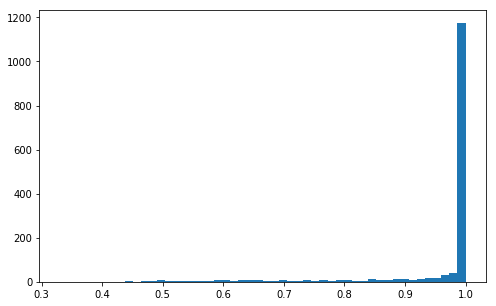

In [13]:
fig, ax = plt.subplots(figsize=(8,5))
prob_max = np.max(test_preds, 1)
ax.hist(prob_max, bins=50);

## Testing accuracy on the first 1500 test elements

In [21]:
test_acc = 100*np.mean(np.argmax(test_preds, axis=1) == y_test[:1500])
print("Test Accuracy: {:0.2f}%".format(test_acc))

Test Accuracy: 93.67%
